In [1]:
import pandas as pd
import numpy as np
from transformers import AutoModel, AutoTokenizer, AutoConfig
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import f1_score, accuracy_score
import os
import pickle
import json
import IPython

SEED = 234523

c:\Users\adrig\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('./dataset/train.csv', index_col='train_idx')
df.drop(['label_text'], inplace=True, axis='columns')
train, validation = train_test_split(df, test_size=0.25, random_state=SEED)

test = pd.read_csv('./dataset/test.csv')

dataset = DatasetDict()
dataset['train'] = Dataset.from_pandas(train)
dataset['validation'] = Dataset.from_pandas(validation)
dataset['test'] = Dataset.from_pandas(test)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_NAME = 'cardiffnlp/twitter-roberta-base-sentiment-latest'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
config = AutoConfig.from_pretrained(MODEL_NAME)
pretrained_model = AutoModel.from_pretrained(MODEL_NAME)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaModel: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
def tokenize(batch):
    tokens = tokenizer(batch['text'], padding='max_length', truncation=True, max_length=512)
    batch['input_ids'], batch['attention_mask'] = tokens['input_ids'], tokens['attention_mask']
    return batch

dataset = dataset.map(tokenize)

dataset['train'].set_format('pt', columns=['input_ids', 'attention_mask', 'label'])
dataset['validation'].set_format('pt', columns=['input_ids', 'attention_mask', 'label'])
dataset['test'].set_format('pt', columns=['input_ids', 'attention_mask'])

dataset['train'] = dataset['train'].remove_columns(['text', 'train_idx'])
dataset['validation'] = dataset['validation'].remove_columns(['text', 'train_idx'])
dataset['test'] = dataset['test'].remove_columns(['text', 'test_idx'])

In [5]:
class SentimentAnalysis(nn.Module):
    def __init__(self):
        super(SentimentAnalysis, self).__init__()
        self.roberta = pretrained_model
        self.fc1 = nn.Linear(768, 512)
        self.activation1 = nn.GELU()
        self.output = nn.Linear(512, 2)

    def forward(self, input_ids, attention_mask):
        x = self.roberta(input_ids, attention_mask).pooler_output
        x = self.activation1(self.fc1(x))
        x = torch.softmax(self.output(x), dim=-1)
        return x

In [6]:
BATCH_SIZE = 4
STEPS_PER_EPOCH = len(dataset['train']) // BATCH_SIZE

train_loader = DataLoader(dataset['train'], batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(dataset['validation'], batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset['test'], batch_size=BATCH_SIZE, shuffle=False)

In [7]:
## It creates the [==>.....] progress bar
def progress_bar(b_idx, perc_steps=25):
    perc_epoch = int(b_idx / STEPS_PER_EPOCH * perc_steps)
    perc_left = perc_steps - perc_epoch
    return perc_epoch, perc_left

## It computes the accumulative f1 for the train set
def train_metrics(b_idx, outputs, labels, y_true, y_pred):
    if b_idx == 0: 
        y_true = labels.detach().cpu().numpy()
        y_pred = torch.argmax(outputs, dim=1).detach().cpu().numpy()
    else: 
        y_true = np.concatenate((y_true, labels.detach().cpu().numpy()))
        y_pred = np.concatenate((y_pred, torch.argmax(outputs, dim=1).detach().cpu().numpy()))
    
    return f1_score(y_true, y_pred), y_true, y_pred

## It computes the estimated time average based on some batch_avg_time * steps_left
def compute_eta(b_idx, start_batch, batch_times):
    batch_times.append(time.time() - start_batch)
    if b_idx == 0: batch_avg_time = batch_times[0]
    else: 
        batch_times = batch_times[-10:]
        batch_avg_time = sum(batch_times) / len(batch_times)
    
    seconds_left = (STEPS_PER_EPOCH - b_idx) * batch_avg_time
    if seconds_left > 60: eta = time.strftime('%M:%S', time.gmtime(seconds_left))
    else: eta = f'{seconds_left:.2f} s'

    return eta, batch_times

## When the epoch finishes, it shows instead of ETA the time the epoch lasted
def time_epoch(start_epoch):
    return f'{int(time.time() - start_epoch)} s'

## Common validation step that compute f1
def validation_step(model, criterion):
    model.eval()
    y_pred, y_true = [], []
    val_losses = []

    with torch.no_grad():
        for batch in validation_loader:
            input_ids, attention_masks = batch['input_ids'].to(device), batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_masks)
            val_losses.append(criterion(outputs, labels).item())
            batch_pred = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            y_pred.append(batch_pred)
            y_true.append(labels.detach().cpu().numpy())
            
    y_pred, y_true = np.concatenate(y_pred), np.concatenate(y_true)
    val_f1 = f1_score(y_true, y_pred)
    val_loss = sum(val_losses) / len(val_losses)
    
    return val_f1, val_loss

## Update ReduceLROnPlateu scheduler based on val_loss
def scheduler_step(scheduler, val_loss):
    scheduler.step(val_loss)
    return scheduler

## Save best model every epoch based on val_f1
def save_model(model, exp, val_f1, best_val_f1):
    if val_f1 > best_val_f1:
        torch.save(model.state_dict(), f'./models/{exp}/model.pt')
        best_val_f1 = val_f1
    return best_val_f1

## MAIN EPOCH STATUS FUNCTION
def epoch_status(b_idx, outputs, labels, start_batch, model, loss, start_epoch, y_true, y_pred, batch_times, best_val_f1, exp, scheduler, criterion):
    perc_epoch, perc_left = progress_bar(b_idx)
    accumulative_f1, y_true, y_pred = train_metrics(b_idx, outputs, labels, y_true, y_pred)
    eta, batch_times = compute_eta(b_idx, start_batch, batch_times)

    val_f1, val_loss = False, False
    if b_idx == STEPS_PER_EPOCH:
        val_f1, val_loss = validation_step(model, criterion)
        scheduler = scheduler_step(scheduler, val_loss)
        eta = time_epoch(start_epoch)
        best_val_f1 = save_model(model, exp, val_f1, best_val_f1)

    print(f'{b_idx}/{STEPS_PER_EPOCH}\t[{"=" * perc_epoch}>{"." * perc_left}] - ETA: {eta} - loss: {loss.item():.4f} - f1: {accumulative_f1:.4f}{"" if not val_f1 else f" - val_f1: {val_f1:.4f}"}', end='\r')
    return batch_times, y_true, y_pred, best_val_f1, scheduler, val_loss, accumulative_f1, val_f1

In [8]:
def train(model, criterion, optimizer, scheduler, epochs=10, experiment=str(time.time())):
    os.makedirs(f'./models/{experiment}', exist_ok=True)
    model = model.to(device)

    best_val_f1 = 0.0
    train_losses, val_losses, train_f1, val_f1 = [], [], [], []
    for epoch in range(epochs):
        model.train()

        print(f'Epoch {epoch+1}/{epochs}')
        start_epoch = time.time()
        batch_times = [] #contains the times that each batch has lasted
        y_true, y_pred = [], [] #accumulates the predictions for each batch
        epoch_loss = []

        for b_idx, batch in enumerate(train_loader):
            start_batch = time.time()

            input_ids, attention_masks = batch['input_ids'].to(device), batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids, attention_masks)

            loss = criterion(outputs, labels)
            epoch_loss.append(loss.item())
            loss.backward()

            optimizer.step()

            batch_times, y_true, y_pred, best_val_f1, scheduler, val_loss, epoch_f1, epoch_val_f1 = epoch_status(b_idx, outputs, labels, start_batch, model, loss, start_epoch, y_true, y_pred, batch_times, best_val_f1, experiment, scheduler, criterion)
        
        train_losses.append(sum(epoch_loss)/len(epoch_loss))
        val_losses.append(val_loss)
        train_f1.append(epoch_f1)
        val_f1.append(epoch_val_f1)
        print()


    history = {
        'train_loss':train_losses,
        'val_loss':val_losses,
        'train_f1':train_f1,
        'val_f1':val_f1
    }
    pickle.dump(history, open(f'./models/{experiment}/logs.pkl', 'wb'))

    return model, history

In [9]:
model = SentimentAnalysis()

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    params=model.parameters(),
    lr=1e-5,
    amsgrad=True,
    weight_decay=0.01
)
scheduler = ReduceLROnPlateau(
    optimizer=optimizer,
    factor=0.1,
    patience=5
)

exp = 'testing'
model, history = train(
    model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=10,
    experiment=exp
)

Epoch 1/10


KeyboardInterrupt: 

<class 'dict'>


C:\Users\adrig\AppData\Local\Temp\ipykernel_21164\2364830428.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


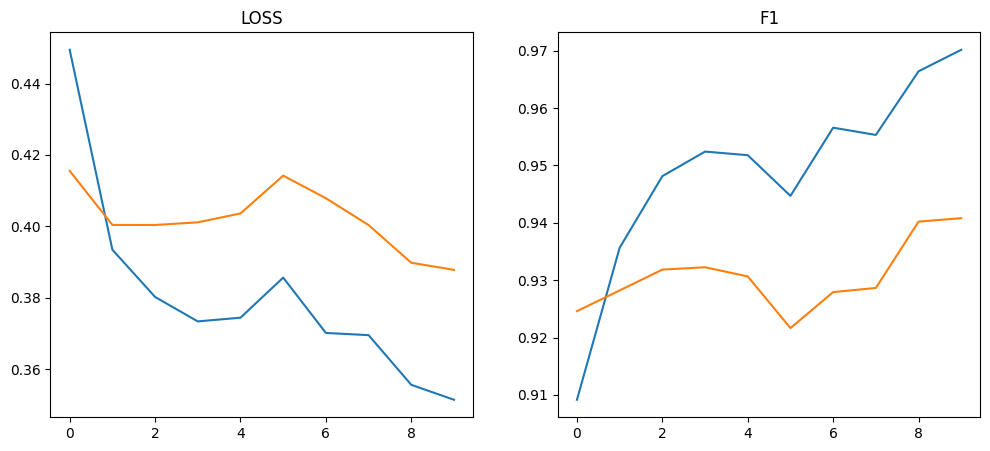

In [36]:
def evaluate(experiment):
    logs = pickle.load(open(f'./models/{experiment}/logs.pkl', 'rb'))

    test_model = SentimentAnalysis()
    test_model.load_state_dict(torch.load(f'./models/{experiment}/model.pt'))
    test_model.to(device)

    test_model.eval()
    y_pred = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_masks = batch['input_ids'].to(device), batch['attention_mask'].to(device)

            outputs = test_model(input_ids, attention_masks)
            batch_pred = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            y_pred.append(batch_pred)
            
    y_pred = np.concatenate(y_pred)

    num_epochs = len(logs['train_loss'])

    plt.figure(figsize=(12, 5))
    plt.title(f'EXPERIMENT: {experiment}')
    plt.subplot(1, 2, 1)
    plt.title('LOSS')
    plt.plot(range(num_epochs), logs['train_loss'])
    plt.plot(range(num_epochs), logs['val_loss'])
    plt.subplot(1, 2, 2)
    plt.title('F1')
    plt.plot(range(num_epochs), logs['train_f1'])
    plt.plot(range(num_epochs), logs['val_f1'])

    predicted_classes = {str(i): int(y) for i, y in enumerate(y_pred)}
    predicted_classes ={'target': predicted_classes}

    print(type(predicted_classes))

    with open(f'./models/{experiment}/results.json', 'w') as f:
        json.dump(predicted_classes, f)

evaluate('testing')